# todo
 _ visualize trips
 - stats to calculate visualize
     - duration 
     - distribution over time
     - distribution by location
     - start to end correlations ? 
     - weekday pairs
     
     

In [54]:
#!pip install geopandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
crs = {'init': 'epsg:4326'}


#get previously processed files
station_geo = gpd.read_file('station_info.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
city_to_region = pd.read_csv('city_region.csv')  #table of region ids by city

In [55]:
# to calculate straight line dist between start and end points using haversine formula

def hd(s):                                #need to accept series or list
    """function takes a series or list containing 2 coordinate pairs s=(lat1, lon1, lat2, lon2)
    returns the haversine distance between the two points represented in km
    """
    r = 6371
    phi1 = np.radians(s[0])
    phi2 = np.radians(s[2])
    delta_phi = np.radians(s[2] - s[0])
    delta_lambda = np.radians(s[3] - s[1])
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)   #in km



In [222]:
#read in file 
filename = '2017-fordgobike-tripdata.csv' #  initial demo setting, override later
def process(f,encoding='utf-8'):
    trips = pd.read_csv(filename, encoding=encoding)
    print(trips.shape)  
    rawcols = trips.columns # 
    
    #drop redundant cols and add features

    trips['duration_min'] = trips.duration_sec.apply(lambda s: s /60) #seconds is not friendly 
    trips.drop(labels=['start_station_name','end_station_name'],axis=1) #dont need these now can, join with station data later
    trips.drop(labels=['duration_sec'],axis=1, inplace=True) #dont need anymore
    dtobj =  pd.DatetimeIndex(trips['start_time'])
    enddt =   pd.DatetimeIndex(trips['end_time'])
                               
    #we will want to work with day of week as well as group trips by time:
    trips['year'] = dtobj.year
    trips['month'] = dtobj.month
    trips['day'] = dtobj.day
    trips['dow'] = dtobj.day_name()  #day of week in english    
    trips['hour'] = dtobj.hour
    trips['time'] = dtobj.time
    trips['end_hour'] = enddt.hour                           
    trips.drop(labels=['start_time','end_time'], axis=1, inplace=True)

    trips['dist_km'] = trips[['start_station_longitude','start_station_latitude',
           'end_station_longitude','end_station_latitude']].apply(hd,axis=1)
    #calculate a speed factor, using straight line dist and trip duration (this is not actual bike velocity)
    ##takes a while
    trips['speedf'] =  trips[['dist_km','duration_min']].apply(lambda x : x[0] / x[1]/60, axis=1)
    
    
    ####
    return trips   ## returns processed datafraem
trips = process(filename) # so we can test as we go

(519700, 13)


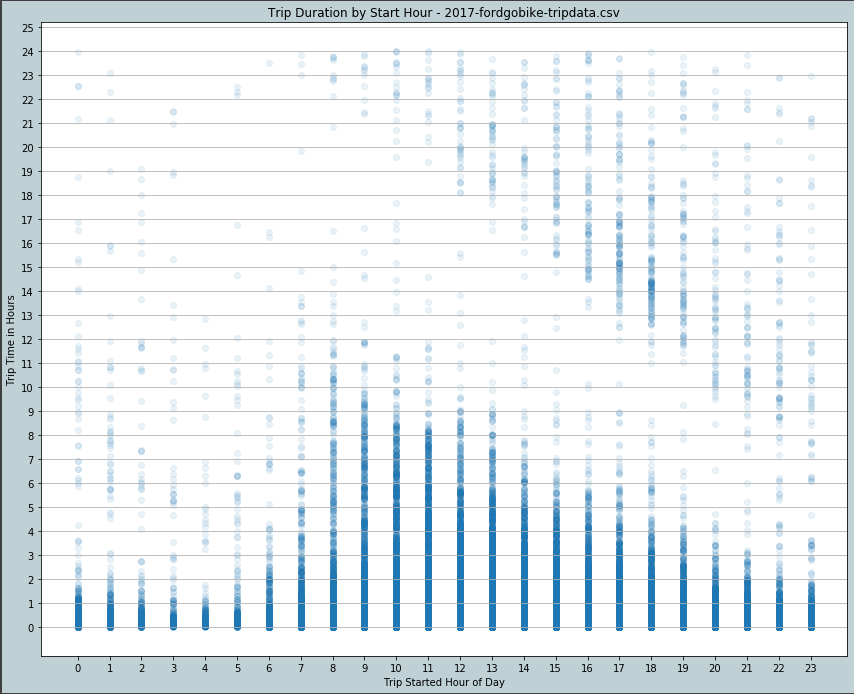

In [230]:
#plot duration stats
%matplotlib inline
#from matplotlib.widgets import Slider # make interacive?
def eda_plot1(trips):   #give it a dataframe 
    y=trips.duration_min/60 #change to hours 
    x=trips.hour
    a_init =.09

    fig= plt.figure(figsize=(14,11),
                    frameon=True,
                    facecolor='#BFD1D4',
                    edgecolor='#404040',
                    linewidth=3)
    ax1= fig.add_axes((.1,.1,.8,.8))
    ax1.scatter(x,y, alpha=a_init)

    ax1.set_title('Trip Duration by Start Hour - '+ filename )
    ax1.set_xticks(range(0,24,1))    
    ax1.set_yticks(range(0,26,1))
    ax1.set_xlabel('Trip Started Hour of Day')
    ax1.set_ylabel('Trip Time in Hours')
    ax1.grid(True, axis='y')
    
    figname = 'edaplot1_' + filename  
    plt.savefig('duration_stats.jpg',facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())
    
eda_plot1(trips)
plt.show()


# Discussion
 The preceding plot certainly presents an interesting pattern: what looks like a fairly normal distribution centered around midday is overshadowed by a complementary cluster of long trips separated by a very empty space.
Looking at the distance in hours it becomes apparent that the 'blank' space would contain trips that ended in the wee hours of the morning. This implies but does not prove that the superior cluster may be the result of renters who keep their bicycles until the next morning. There may be other explanations for the patterns in trip end times, but we can't decide anything at this point, other than that the period between 3 and 4 am is the most unpopular time to start and end a trip.

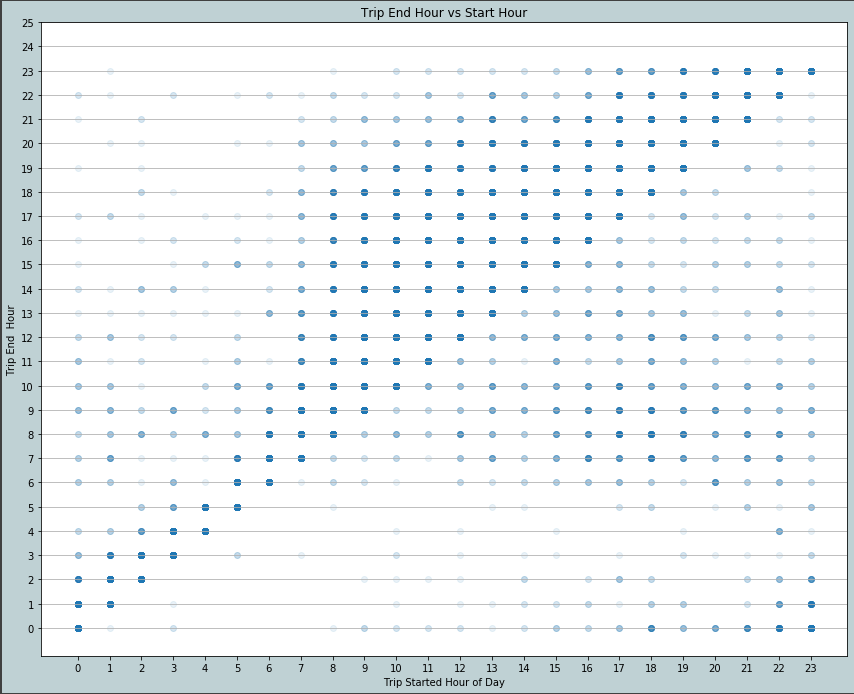

In [58]:
#plot duration stats
%matplotlib inline

y=trips.end_hour
x=trips.hour
a_init =.09

fig= plt.figure(figsize=(14,11),
                frameon=True,
                facecolor='#BFD1D4',
                edgecolor='#404040',
                linewidth=3)
#ax1 = plt.subplot(111)
ax1= fig.add_axes((.1,.1,.8,.8))

ax1.scatter(x,y, alpha=a_init)

ax1.set_title('Trip End Hour vs Start Hour')
ax1.set_xticks(range(0,24,1))    
ax1.set_yticks(range(0,26,1))
ax1.set_xlabel('Trip Started Hour of Day')
ax1.set_ylabel('Trip End  Hour')
ax1.grid(True, axis='y')

plt.savefig('duration_stats.jpg',facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())
plt.show()


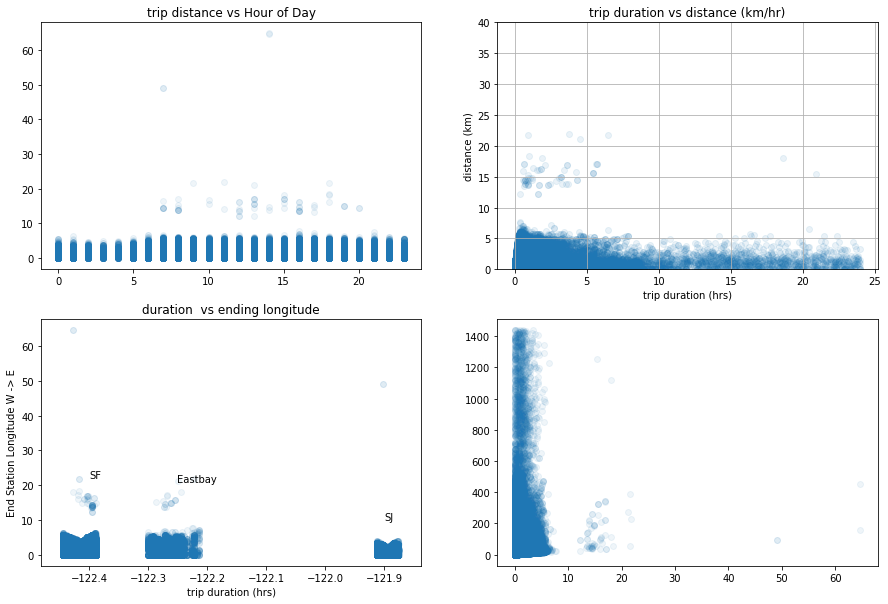

In [59]:
#whats this plot about

fig= plt.figure(figsize=(15,10))

ax2 = plt.subplot(221)
ax3 = plt.subplot(222)
ax4 = plt.subplot(223)
ax5 = plt.subplot(224)

ax2.scatter(trips.hour, trips.dist_km, alpha =.07)
ax2.set_title('trip distance vs Hour of Day')

ax3.scatter(trips.duration_min/60, trips.dist_km, alpha =.09)
ax3.set_title('trip duration vs distance (km/hr)')
ax3.set_ylim(0,40) #dont look at unreasonable values
ax3.set_ylabel('distance (km)')
ax3.set_xlabel('trip duration (hrs)')
ax3.grid(True)
ax4.scatter(trips.end_station_longitude, trips.dist_km, alpha =.07)
ax4.set_ylabel('End Station Longitude W -> E')
ax4.set_xlabel('trip duration (hrs)')
ax4.set_title('duration  vs ending longitude')
ax4.text(-122.4, 22, 'SF')
ax4.text(-122.25, 21, 'Eastbay')
ax4.text(-121.9, 10, 'SJ')

ax5.scatter(trips.dist_km, trips.duration_min, alpha =.07)
plt.show()


# Pricing Information:
The current pricing scheme is located here: 

    * [E-bike Pricing](https://help.baywheels.com/hc/en-us/articles/360039662872-Ebike-pricing)
    * [Classic Bike Pricing](https://www.lyft.com/bikes/bay-wheels/pricing)
    
It was used to create the costing functions below, allowing us to get an idea of what that average revenue from a rental could be. 


In [60]:
#current pricing source https://help.baywheels.com/hc/en-us/articles/360039662872-Ebike-pricing
# https://www.lyft.com/bikes/bay-wheels/pricing

def member_price(duration_min):
    return int((duration_min - 45 ) / 15) * 3 # As a member, you’ll receive unlimited 45-minute trips on our Classic bikes and discounted ebike per minute pricing. If you keep a Classic bike out longer than 45 minutes at a time, it’s an extra $3 per additional 15 minutes
def customer_price(duration_min):
    return 2 + int(duration_min - 30) * 3   #$2 for one ride up to 30 minutes - perfect for getting you where you need to go. If your ride lasts longer than 30 minutes, it’s an extra $3 per additional 15 minutes. Available in app only. Ebike pricing applies to ebike trips

def member_ebike(duration_min):
    return duration_min * 0.15 + member_price(duration_min)
def customer_ebike(duration_min):
    return duration_min * 0.20 + customer_price(duration_min)

##

def tripcost(member,ebike,dur):
    if member & ebike:
        return member_ebike(dur)
    elif member & ~ebike:
        return member_price(dur)
    elif ~member & ebike:
        return customer_ebike(dur)
    else:  
        return customer_price(dur)


In [61]:
def make_geodf(trips):
#start to generate the geometry ...
    startpoints= gpd.points_from_xy(trips.start_station_longitude, trips.start_station_latitude)
    endpoints= gpd.points_from_xy(trips.end_station_longitude, trips.end_station_latitude)

    trips_geo = gpd.GeoDataFrame(trips.copy(),crs=crs,geometry= startpoints)
    trips_geo['endpoints'] = endpoints
    #interesting. quite a few return to same location ... ##will need to have a look

    trips_geo.rename(columns={'geometry': 'startpoints'}, inplace=True)
    trips_geo['tripline'] = trips_geo[['startpoints','endpoints']].apply(lambda x : LineString([x['startpoints'], x['endpoints']]),axis=1 )
    trips_geo.set_geometry('tripline', inplace=True)
    return trips_geo
#chain 
trips_geo = make_geodf(trips)

#debug remove
test= trips_geo[['startpoints','endpoints']]
ls = test.apply(lambda p : LineString([p['startpoints'],p['endpoints']]),axis=1)
type(ls)


In [62]:

trips_geo.geometry

0         LINESTRING (-122.42624 37.77643, -122.41593 37...
1         LINESTRING (-122.40088 37.78487, -122.42661 37...
2         LINESTRING (-122.26776 37.87035, -122.26776 37...
3         LINESTRING (-122.40945 37.77452, -122.40844 37...
4         LINESTRING (-122.25876 37.86881, -122.26590 37...
                                ...                        
519695    LINESTRING (-122.39317 37.77588, -122.40513 37...
519696    LINESTRING (-122.39274 37.77874, -122.40307 37...
519697    LINESTRING (-122.40081 37.78963, -122.39271 37...
519698    LINESTRING (-122.41739 37.77662, -122.41895 37...
519699    LINESTRING (-122.39740 37.78752, -122.39271 37...
Name: tripline, Length: 519700, dtype: geometry

count    18134.000000
mean        65.485263
std        127.216493
min          1.016667
25%         11.433333
50%         28.766667
95%        249.251667
max       1439.483333
Name: duration_min, dtype: float64


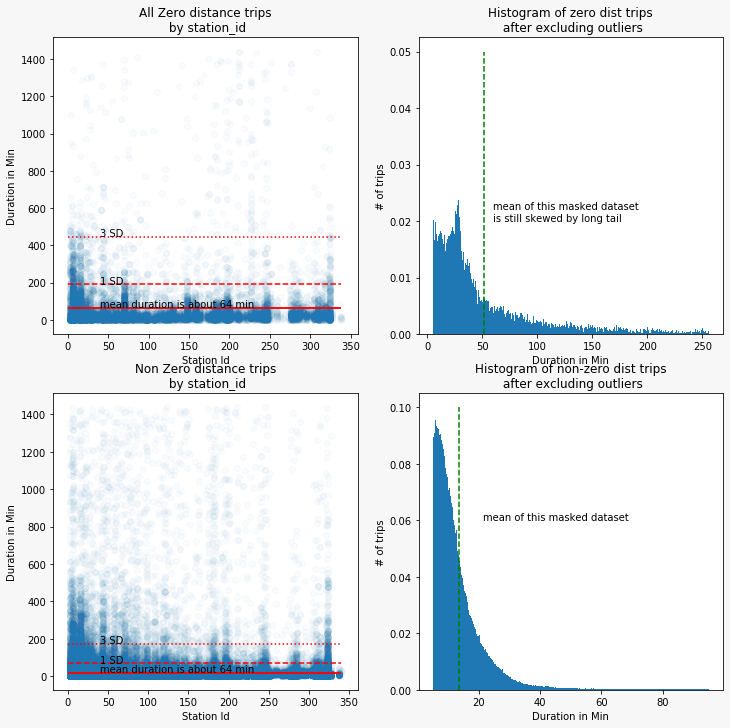

masked nonzero distance trips count    419524.000000
mean         13.601916
std           9.764941
min           5.000000
25%           7.733333
50%          10.883333
95%          29.400000
max          95.200000
Name: duration_min, dtype: float64


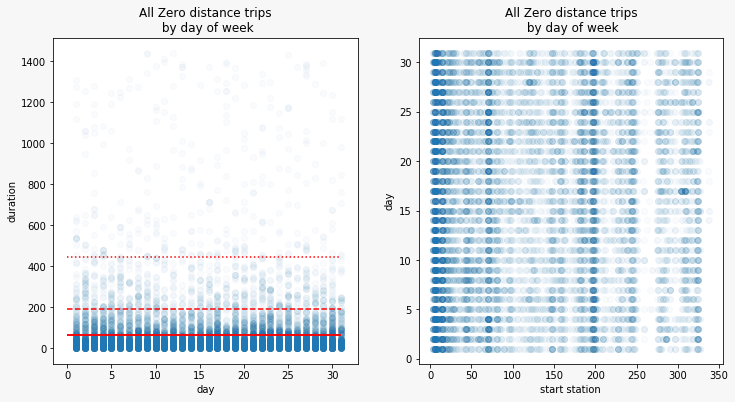

RangeIndex(start=0, stop=454, step=1)

In [63]:
#a look at trips that start and end at the same station
# these trips may need to be excluded as they seem to have some extreme values

zero_dist = trips.dist_km == 0

print(trips[zero_dist].duration_min.describe([.25,.5,.95]))
trips.duration_min.describe()
trips[~zero_dist].duration_min.describe([.25,.5,.95])  ## maybe we can toss trips over 

fig= plt.figure(figsize=(12,12),frameon=True, facecolor='#F7F7F7')
ax1  = plt.subplot(221)
ax2  = plt.subplot(222)

x=trips[zero_dist].start_station_id
y=trips[zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax1.set_title('All Zero distance trips\n by station_id')
ax1.set_xlabel('Station Id')
ax1.set_ylabel('Duration in Min')
ax1.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax1.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax1.text(40,dur_mean+dur_std+1, '1 SD')
ax1.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax1.text(40,dur_mean+3*dur_std+2, '3 SD')


ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.scatter(x,y, alpha=.025)


lbound = 5 <= trips[zero_dist].duration_min   # dur_mean-2*dur_std <= trips[zero_dist].duration_min
ubound = trips[zero_dist].duration_min <= dur_mean+1.5*dur_std
bounded = lbound & ubound
zd_trips = trips[zero_dist][bounded]

ax2.set_title('Histogram of zero dist trips\n after excluding outliers')
ax2.hist(zd_trips.duration_min, bins= 300,  density=True, stacked=True)


ax2.vlines(zd_trips.duration_min.mean(),0, .05, colors='g',linestyles ='dashed')
ax2.text(zd_trips.duration_min.mean()+ 8 ,.02, 'mean of this masked dataset\nis still skewed by long tail')
ax2.set_ylabel('# of trips')
ax2.set_xlabel('Duration in Min')
#compare to non-zero dist trips.//
ax3  = plt.subplot(223)
ax4  = plt.subplot(224)

x=trips[~zero_dist].start_station_id
y=trips[~zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax3.set_title('Non Zero distance trips\n by station_id')
ax3.set_xlabel('Station Id')
ax3.set_ylabel('Duration in Min')
ax3.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax3.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax3.text(40,dur_mean+dur_std+1, '1 SD')
ax3.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax3.text(40,dur_mean+3*dur_std+2, '3 SD')


ax3.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax3.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax3.scatter(x,y, alpha=.025)

#hist of non zero dist trips after discarding outliers

dz_trips =  trips[~zero_dist].duration_min
lbound = 5 <= dz_trips  # dur_mean-2*dur_std <= trips[zero_dist].duration_min
ubound = dz_trips <=  dz_trips.mean()+1.5* dz_trips.std()
bounded = lbound & ubound

x=  trips[~zero_dist][bounded].duration_min

ax4.set_title('Histogram of non-zero dist trips\n after excluding outliers')
ax4.hist(x, bins= 300, density=True, stacked=True)
ax4.vlines(x.mean(),0, .1, colors='g',linestyles ='dashed')
ax4.text(x.mean()+ 8 ,.06, 'mean of this masked dataset')
ax4.set_ylabel('# of trips')
ax4.set_xlabel('Duration in Min')
plt.savefig('eda_zero_dist_trips.jpg')
plt.show()
print('masked nonzero distance trips' , x.describe([.25,.5,.95]))
#one last scatter by day of week

fig= plt.figure(figsize=(12,6),frameon=True, facecolor='#F7F7F7')
ax1  = plt.subplot(121)
x=trips[zero_dist].day
y=trips[zero_dist].duration_min
dur_mean = y.mean()
dur_std = y.std()
ax1.set_title('All Zero distance trips\n by day of week')
ax1.set_xlabel('day' )
ax1.set_ylabel('duration')
ax1.hlines(y.mean()+y.std(),0,x.max(), colors='r', linestyles='dashed',label ='zero dist 1 std')
ax1.text(40,dur_mean + 2, 'mean duration is about 64 min')
ax1.text(40,dur_mean+dur_std+1, '1 SD')
ax1.hlines(y.mean()+3*dur_std,0,x.max(), colors='r', linestyles='dotted',label ='zero dist 3 std')
ax1.text(40,dur_mean+3*dur_std+2, '3 SD')


ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.hlines(y.mean(),0,x.max(), colors='r', label ='zero dist mean')
ax1.scatter(x,y, alpha=.025)

## day vs station
ax2  = plt.subplot(122)

x=trips[zero_dist].start_station_id
y=trips[zero_dist].day
ax2.set_title('All Zero distance trips\n by day of week')
ax2.set_xlabel('start station' )
ax2.set_ylabel('day')
ax2.scatter(x,y, alpha=.025)
plt.show()
station_geo.index


##conclusion : the dataset has some issues with outlier data. its not clear why there are some many extreme 
values for trip duration. Its possible that there is measurement erorr caused by bikes losing connectivity before
the end of the trip. given the theoretical costs associated with these trips, its unlikely that they represent 
actual trip durations. Finallly when we look at the zero distance trips by station, we can see that there are 
definite patterns. Some stations have a much higher incidence. These stations are likely to correlate with busy downtown
locations, or locations that have a problem with bikes going awol.
since our main line of inquiry is 'where are they going, its interesting to see that so
many trips return to their starting station, these dont give us much to analyse so other than noting their prevalence
we will ignore them from here out


In [64]:
#stations with most zero dist trips 

biggest_zeros =trips[zero_dist][[
    'start_station_id',
    'start_station_name',
    'duration_min']].reset_index().groupby(by=['start_station_id',
                                               'start_station_name']).agg({'duration_min': 'mean',
                                                                           'index': 'count'}).sort_values('index',ascending=False).head(50)


In [118]:

#going to start slimming down our geo dataframe. we want to look at only trips that start in SF
#we also want to exclude trips that start and end at the same station


def selectSF(alltrips):
    if (station_geo.index.name != 'station_id'):
        station_geo.set_index('station_id', inplace=True)
    if (alltrips.index.name != 'start_station_id'):    
        alltrips.set_index('start_station_id',inplace=True)
    regionSF = station_geo['region_id'] == '3'  #condition
    station_geo[regionSF].index  #index is all station ids in region 3(SF)


    start_in_SF = alltrips.index.isin(station_geo[regionSF].index)  #c
    end_in_SF = alltrips.set_index('end_station_id').index.isin(station_geo[regionSF].index)  #if they dont tehy mess up the map
    SF_is_the_alpha_omega = start_in_SF & end_in_SF
    sftrips =  alltrips[start_in_SF]
    sftrips =  alltrips[SF_is_the_alpha_omega].reset_index()
    nonzerodist = sftrips.start_station_id != sftrips.end_station_id  
    sftrips = sftrips[nonzerodist]                 ##non zero dist!! 
    
    #lets get the columns organized:

    geomcols = ['startpoints','endpoints','tripline']
    datecols= ['time']
    numcols = ['duration_min','start_station_latitude','start_station_longitude', 
               'end_station_latitude', 'end_station_longitude', 
               'dist_km', 'speedf', 'year', 'month','day']
    catcols =    ['start_station_id','end_station_id',
                  'user_type','bike_id','dow']
    dropcols = ['start_station_latitude','start_station_longitude','end_station_latitude', 'end_station_longitude']
    for c in catcols:
        sftrips[c] = sftrips[c].astype('category')

    sftrips.drop(labels=dropcols, axis=1, inplace=True)
    reorder = ['bike_id', 'user_type','start_station_id','end_station_id','duration_min', 'dist_km', 'speedf','dow', 'year',
       'month', 'day',  'hour', 'time', 'start_station_name', 
       'end_station_name', 'startpoints', 'endpoints', 'tripline']
    sftrips = sftrips[reorder]
    return sftrips

sftrips = selectSF(trips_geo)               #chain

In [226]:
##global vars for plotting trips

map = gpd.read_file('geo/bayarea/tl_2019_06075_roads.shp')

#TODO : CHECK file encoding from lyft

filelist = ['201801-fordgobike-tripdata.csv','201806-fordgobike-tripdata.csv',
            '201901-fordgobike-tripdata.csv','201906-baywheels-tripdata.csv',
            '202001-baywheels-tripdata.csv']
filelist = ['201806-fordgobike-tripdata.csv',
            '201901-fordgobike-tripdata.csv','201906-baywheels-tripdata.csv',
            '202001-baywheels-tripdata.csv']
triplist = []

for f in filelist:
    print('processing ',f,'.....')
    triplist.append(selectSF(make_geodf(process(f,'utf-8'))))
    


processing  201806-fordgobike-tripdata.csv .....
(519700, 13)
processing  201901-fordgobike-tripdata.csv .....
(519700, 13)
processing  201906-baywheels-tripdata.csv .....
(519700, 13)
processing  202001-baywheels-tripdata.csv .....
(519700, 13)


In [216]:
#'201801-fordgobike-tripdata.csv'
!head 201801-fordgobike-tripdata.csv


duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip
75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120,Mission Dolores Park,37.7614205,-122.4264353,285,Webster St at O'Farrell St,37.7835208353,-122.4311578274,2765,Subscriber,No
85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15,San Francisco Ferry Building (Harry Bridges Plaza),37.795392,-122.394203,15,San Francisco Ferry Building (Harry Bridges Plaza),37.795392,-122.394203,2815,Customer,No
71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304,Jackson St at 5th St,37.3487586867,-121.8947978318,296,5th St at Virginia St,37.3259984,-121.87712,3039,Customer,No
61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75,Market St at Franklin St,37.7737932061,-122.4212390184,47,4th St at Harrison St,37.7809545996,-122.3997491598,321,Customer

In [150]:
#kludge to save files later for speed
#will take up a few hundred MB
for idx,f in enumerate(triplist):
    name = 'geo_' + filelist[idx]
    f.to_csv(name)
    


In [156]:
from matplotlib import colors
cmap = colors.ListedColormap(['k','b','y','g','r'])


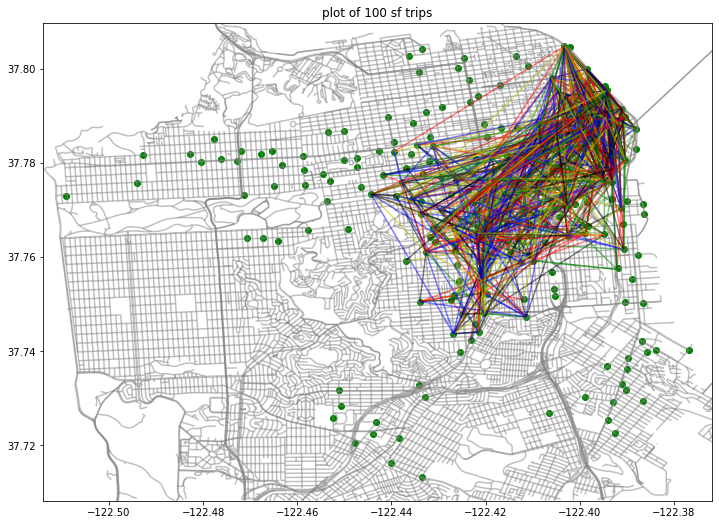

In [199]:
#plot set  on map
#load the streetmap


fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot()

xl = station_geo.lon.min() - .005
xr = station_geo[sf_proper].lon.max() + .005
yb =  station_geo[sf_proper].lat.min() - .005
yt =  station_geo[sf_proper].lat.max() + .005
ax1.set_xlim(xl,xr)
ax1.set_ylim(yb,yt)
map.plot(ax=ax1, alpha= 0.5, color='grey')
title = 'plot of 100 sf trips'
ax1.set_title(title)

samplesize = 200       # too many observations to plot

sftrips.sample(n=samplesize, axis=0).plot(ax=ax1, color='yellow', alpha=0.02) #plot the geoseries

station_geo.plot(ax=ax1, color='green')

sf201801.sample(n=samplesize, axis=0).plot(ax=ax1, color='red', alpha=0.015) #plot the geoseries
#
for idx, gdframe in enumerate(triplist):
    gdframe.sample(n=samplesize, axis=0).plot(ax=ax1, cmap=cmap , alpha=0.5) #plot the geoseries
    filename = filelist[idx] + '.jpg'
    plt.savefig(filename)
plt.show()


In [212]:
for idx,d in enumerate(triplist):
    print(idx, d.shape)
    

0 (354059, 18)
1 (354059, 18)
2 (354059, 18)
3 (354059, 18)
4 (354059, 18)
5 (354059, 18)


708.118


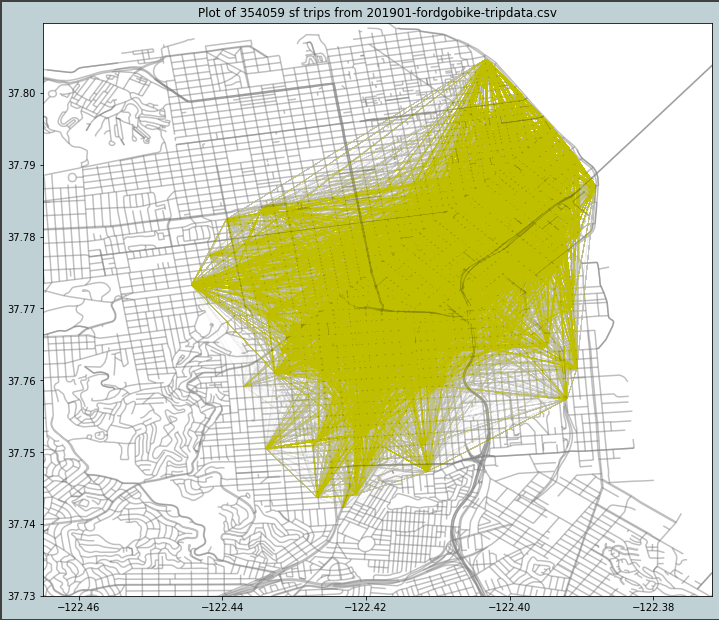

In [208]:
#plot single set on map 

listindex = 2          #position in file and corresponding dataframe list
n= triplist[listindex].shape[0]   
alpha = .002
print (n * alpha)
savefilename =  filelist[1] + '-only.jpg'
title = 'Plot of ' + str(n) + ' sf trips from ' + filelist[listindex]

fig = plt.figure(figsize=(12,12),
                frameon=True,
                facecolor='#BFD1D4',
                edgecolor='#404040',
                linewidth=3)
                
ax1 = plt.subplot()

#set some tighter boundaries as we find unused areas
xl = -122.46 - .005
xr = station_geo[sf_proper].lon.max() + .005
yb =  37.73
yt =  station_geo[sf_proper].lat.max() + .005

ax1.set_xlim(xl,xr)
ax1.set_ylim(yb,yt)
ax1.set_title(title)

map.plot(ax=ax1, alpha= 0.5, color='grey')    #plot the base street maps. #todo: coastline & background fill

triplist[1].plot(ax=ax1, color='y' , alpha=alpha) #plot the lines on same axes

plt.savefig(savefilename)
plt.show()


In [ ]:
total_bikes = trips.bike_id.count()
bybike = trips.groupby('bike_id')
trips.reset_index().groupby(by=['bike_id', 'start_station_name','end_station_name']).count()

In [ ]:
pairs = trips_geo.copy()
pairs =pairs[['start_station_id','end_station_id','duration_min','time','month','dow']]
pairs = pairs.dropna(axis=0, how='all')
pair_summary = pairs.groupby(['start_station_id',
                              'end_station_id']).agg({'duration_min': ['mean','min','max', 'std'], 'time': 'count'}).dropna(axis=0, how='all')
pair_summary.shape
